In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov
import nmf.bayes

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

import matplotlib
import pickle

from theory.represent import rescale_WH

from read_data.reading import read_face_images, images_matrix_grid,\
                                roll_images, unroll_images 

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                              compare_performance, plot_performance_dict,\
                              torch_algo_wrapper, plot_errors_dict,\
                              plot_ratios_gpu_algo, plot_ratios_cpu_gpu, plot_ratios_cpu_algo,\
                              plot_differences_gpu_algo, plot_differences_cpu_gpu, plot_differences_cpu_algo

In [17]:
image_data = read_face_images("data/att_faces/images").astype(float)

In [5]:
print(image_data[0].shape, "{:.2f}".format(image_data.nbytes / 2**10), 
          "{:.2f}".format(image_data.nbytes / 2**20))

(112, 92) 32200.00 31.45


In [ ]:
(112, 92) 32200.00 31.45

<IPython.core.display.Javascript object>


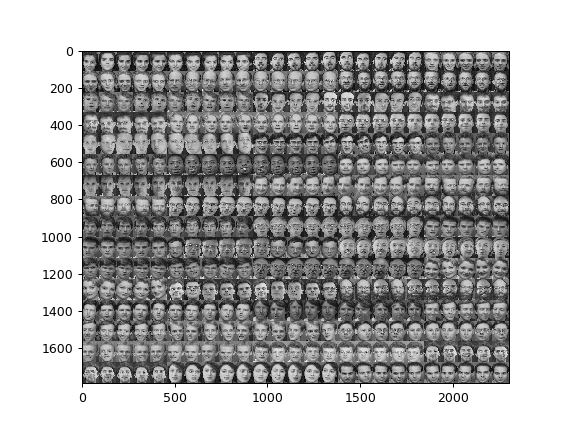

In [4]:
grid = images_matrix_grid(image_data, (16, 25))
plt.imshow(grid, cmap="gray")

In [19]:
unrolled_image_data, ori_shape = unroll_images(image_data)

In [6]:
unrolled_image_data.shape

(400, 10304)

In [7]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [ ]:
errors_result = errors_at_time_t_over_inner_dim(unrolled_image_data, range(5, 360, 20),
                             30, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

In [ ]:
f, ax = plt.subplots()
plot_dict(errors_result, ax, log=False)

In [ ]:
shape = unrolled_image_data.shape
inner_dims = [2, 25, 50, 100, 150, 200]
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

performances = {}
for inner_dim in inner_dims:
    performance = compare_performance(unrolled_image_data, 
                                      inner_dim, time_limit=100,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)
    performances[inner_dim] = performance

In [ ]:
for inner_dim in inner_dims:
    f, ax = plt.subplots()
    ax.set_title("inner_dim = {}".format(inner_dim))
    performance = performances[inner_dim]
    plot_performance(performance, ax)

In [3]:
errors_dict = pickle.load(open("faces_data_errors_dict.pkl", "rb"))

In [24]:
inner_dim = 25

shape = unrolled_image_data.shape
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

In [9]:
errors_dict = compare_performance(unrolled_image_data, 
                                      inner_dim, time_limit=100,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)

Starting mult
Starting pgrad
Starting nesterov
Starting mult_torch
Starting pgrad_torch
Starting nesterov_torch


In [3]:
pickle.dump(errors_dict, open("faces_data_errors_dict.pkl", "wb"))

NameError: name 'errors_dict' is not defined

In [ ]:
errors_dict

# Ratios

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

gridspec_kw = dict(wspace=0.4, hspace=0.5,
                    top=0.85,
                    bottom=0.1,
                    left=0.1, right=0.95)

In [5]:
shape = (400, 10304)
nmbytes = 31.45
inner_dim = 25

<IPython.core.display.Javascript object>


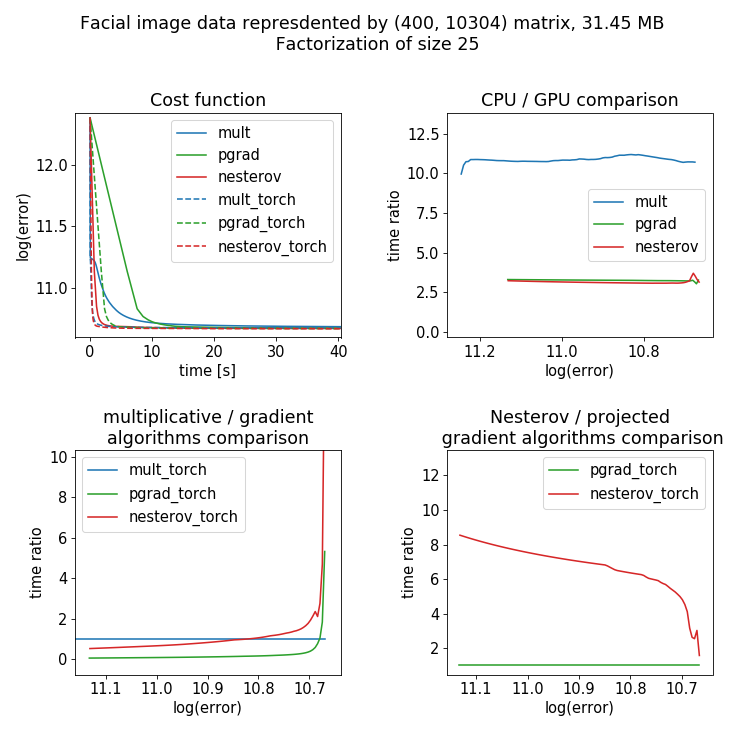

Text(0.5,1,'Nesterov / projected\n gradient algorithms comparison')

In [7]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), 
                       gridspec_kw=gridspec_kw)

# shape = reuters_data.shape
# nbytes = reuters_data.toarray().nbytes


f.suptitle("Facial image data represdented by {0} matrix, {2:.2f} MB \n Factorization of size {1}".format(shape, inner_dim,
                                                                       nmbytes))


plot_errors_dict(errors_dict, axes[0, 0], log=True, title="Cost function", x_lbl="time [s]")
plot_ratios_cpu_gpu(errors_dict, axes[0, 1])
# plot_ratios_cpu_algo(errors_dict, axes[0, 1:], selected_algs=["mult", "pgrad", "nesterov"])
plot_ratios_gpu_algo(errors_dict, axes[1, 0:], selected_algs=["mult_torch", "pgrad_torch", "nesterov_torch"])

axes[0, 1].set_title("CPU / GPU comparison")
axes[1, 0].set_title("multiplicative / gradient\nalgorithms comparison")
axes[1, 1].set_title("Nesterov / projected\n gradient algorithms comparison")


# Differences

<IPython.core.display.Javascript object>


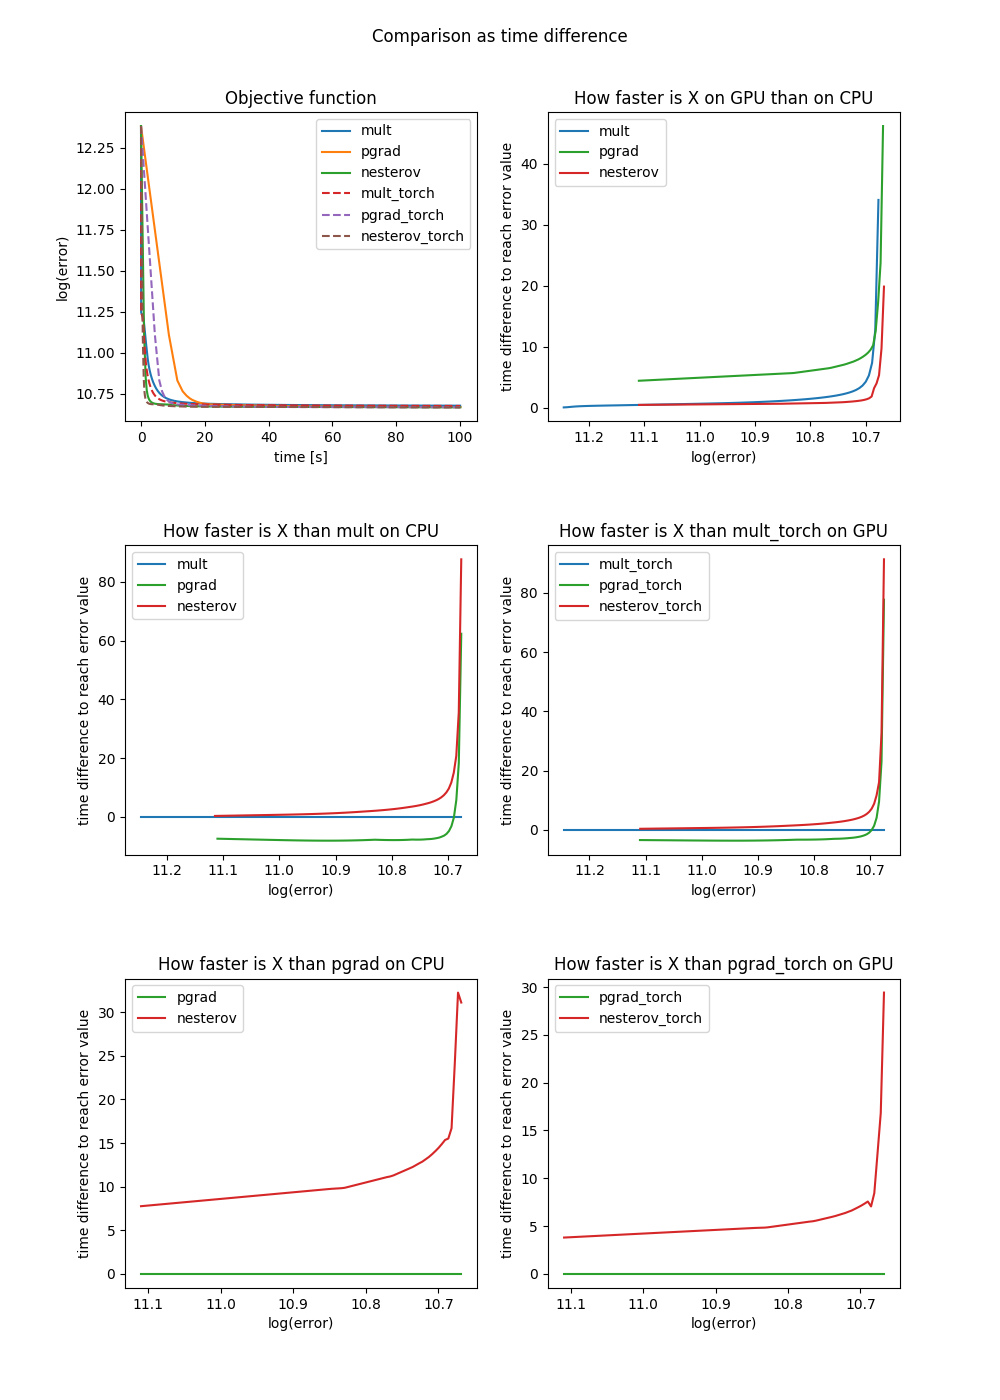

In [33]:
f, axes = plt.subplots(3, 2, figsize=(10, 14), gridspec_kw=dict(hspace=0.4, top=0.92, bottom=0.08))
f.suptitle("Comparison, time difference")

plot_errors_dict(errors_dict, axes[0, 0], log=True, title="Objective function", x_lbl="time [s]")

plot_differences_cpu_gpu(errors_dict, axes[0, 1])
plot_differences_cpu_algo(errors_dict, axes[1:, 0])
plot_differences_gpu_algo(errors_dict, axes[1:, 1])

In [21]:
nesterov = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, device="cuda")
W, H = nesterov(V=unrolled_image_data, inner_dim=25, time_limit=40, max_steps=np.inf)

In [22]:
W, H = rescale_WH(W, H)

<IPython.core.display.Javascript object>


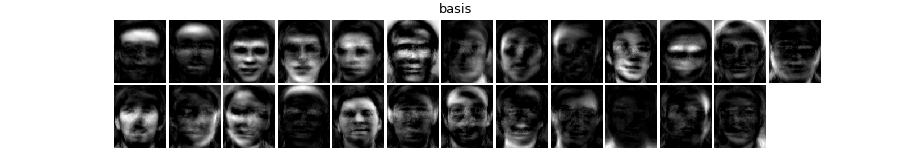

In [48]:
basis = roll_images(H, ori_shape)

f, axs = plt.subplots(2, 13, gridspec_kw=dict(hspace=0.01, wspace=0.05))
axs = axs.ravel()
for ax in axs:
    ax.axis('off')

f.suptitle("basis", size=14)

for i in range(25):
    ax = axs[i]
    ax.imshow(basis[i], cmap="gray"); 

<IPython.core.display.Javascript object>


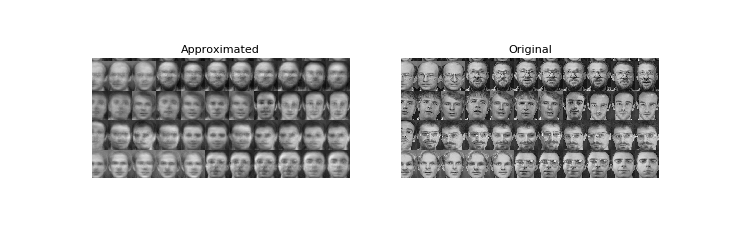

(-0.5, 1471.5, 2799.5, -0.5)

In [61]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharex=True, sharey=True)

approx_unrolled_image_data = W @ H
approx_image_data = roll_images(approx_unrolled_image_data, ori_shape)
grid = images_matrix_grid(approx_image_data, (25, 16))
ax1.imshow(grid, cmap="gray"); ax1.set_title("Approximated")
grid = images_matrix_grid(image_data, (25, 16))
ax2.imshow(grid, cmap="gray"); ax2.set_title("Original")

ax1.axis("off")
ax2.axis("off")

In [54]:
! ls ./data/att_faces/approx_ori

In [59]:
plt.ioff()


approx_unrolled_image_data = W @ H
approx_image_data = roll_images(approx_unrolled_image_data, ori_shape)

for i in range(approx_image_data.shape[0]):
    f, [ax1, ax2] = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax1.imshow(approx_image_data[i], cmap="gray"); ax1.set_title("Approximated")
    ax2.imshow(image_data[i], cmap="gray"); ax2.set_title("Original")
    ax1.axis("off")
    ax2.axis("off")
    f.savefig("data/att_faces/approx_ori/" + str(i) + ".png", bbox_inches='tight')
    plt.close(f)
    
plt.ion()   

# Problem with Bayesian

In [18]:
W, H, errors_t = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm)(
                        V=unrolled_image_data,
                        inner_dim=25, 
                        max_steps=8000,
                        time_limit=5,
                        record_errors=True)

In [19]:
W, H, errors = nmf.bayes.factorise_ICM(unrolled_image_data, 25, 
                                       max_steps=80000, time_limit=60, record_errors=True)

<IPython.core.display.Javascript object>


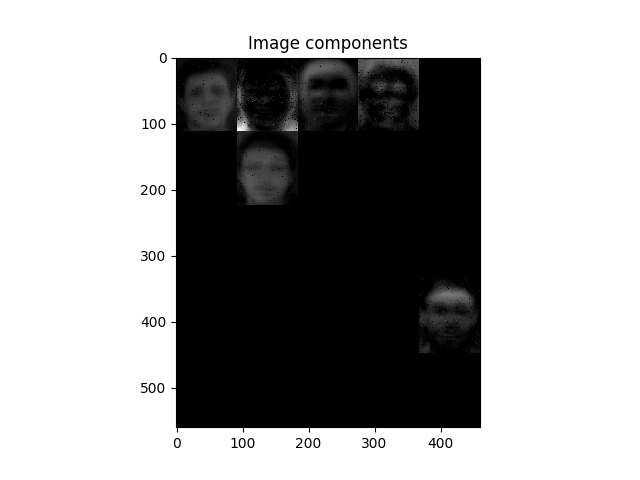

Text(0.5,1,'Image components')

In [20]:
image_components = roll_images(H, ori_shape)
grid = images_matrix_grid(image_components, (5, 5))
f, ax = plt.subplots()
ax.imshow(grid, cmap="gray")
ax.set_title("Image components")